In [11]:
import numpy as np
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm #Progress bar for for loop.
import csv
import cv2
import scipy
import os

In [2]:
epochs = 20
BASE_DIR = '/volumes/data/wht_bld_cell_clasfy/'
batch_size = 32

In [3]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

    return model

In [4]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []

    for wbc_type in os.listdir(folder):
        if not wbc_type.startswith('.'):
            if wbc_type in ['NEUTROPHIL', 'EOSINOPHIL']:
                label = 'POLYNUCLEAR'
            else:
                label = 'MONONUCLEAR'
            for image_filename in tqdm(os.listdir(folder + wbc_type)):
                img_file = cv2.imread(folder + wbc_type + '/' + image_filename)
                if img_file is not None:
                    # Downsample the image to 120, 160, 3
                    img_file = scipy.misc.imresize(arr=img_file, size=(120, 160, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [5]:
X_train, y_train = get_data(BASE_DIR + 'images/TRAIN/')
X_test, y_test = get_data(BASE_DIR + 'images/TEST_SIMPLE/')

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

100%|██████████| 6/6 [00:00<00:00, 36.28it/s]


In [6]:
X_train = X_train * 1./255.  #Getting data in 0-1 range
X_test = X_test * 1./255.

In [7]:
model = get_model()

model_checkpoint = ModelCheckpoint('binary_pred_weights.h5', monitor='val_loss', save_best_only=True)
early_s = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    
history = model.fit(
                    X_train,
                    y_train,
                    callbacks=[model_checkpoint,early_s],
                    validation_split=0.2,
                    epochs=epochs,
                    shuffle=True,
                    batch_size=batch_size, verbose = 1)

model.load_weights('binary_pred_weights.h5')
model.save('binary_pred.h5')

Train on 7975 samples, validate on 1994 samples
Epoch 1/20
7975/7975 [==============================] - 22s - loss: 0.6903 - acc: 0.6183 - val_loss: 0.8478 - val_acc: 0.0000e+00
Epoch 2/20
7975/7975 [==============================] - 14s - loss: 0.6673 - acc: 0.6261 - val_loss: 1.3311 - val_acc: 0.0000e+00
Epoch 3/20
7975/7975 [==============================] - 14s - loss: 0.6218 - acc: 0.6622 - val_loss: 1.0096 - val_acc: 0.0271
Epoch 4/20
7975/7975 [==============================] - 14s - loss: 0.4633 - acc: 0.8008 - val_loss: 1.0758 - val_acc: 0.3666
Epoch 5/20
7975/7975 [==============================] - 14s - loss: 0.3151 - acc: 0.8777 - val_loss: 0.2603 - val_acc: 0.9323
Epoch 6/20
7975/7975 [==============================] - 14s - loss: 0.2763 - acc: 0.9136 - val_loss: 0.3270 - val_acc: 0.8230
Epoch 7/20
7975/7975 [==============================] - 14s - loss: 0.2036 - acc: 0.9324 - val_loss: 0.1427 - val_acc: 0.9529
Epoch 8/20
7975/7975 [==============================] - 14s - 

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    plt.rcParams["figure.figsize"] = [15,5]
    # summarize history for loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss']), plt.plot(history.history['val_loss'])
    plt.title(' model loss'), plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right',prop={'size': 12})
    # summarize history for accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['acc']), plt.plot(history.history['val_acc'])
    plt.title(' model accuracy'), plt.ylabel('accuracy'), plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right',prop={'size': 12})
    plt.show()
    print('Last epoch train accuracy:', history.history['acc'][-1])
    print('Last epoch test accuracy:', history.history['val_acc'][-1])

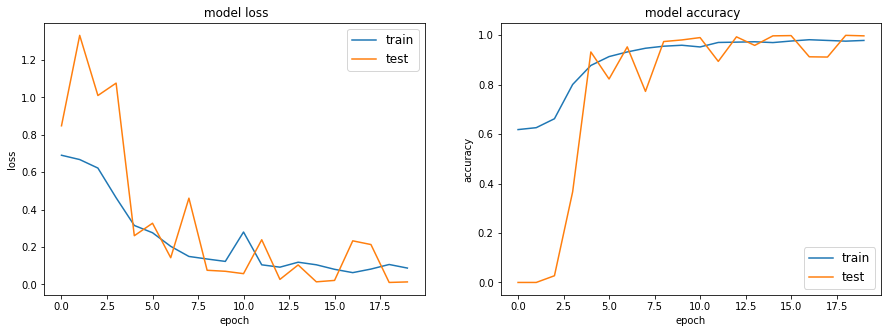

Last epoch train accuracy: 0.978934169279
Last epoch test accuracy: 0.997492477432


In [9]:
plot_history(history)

In [10]:
from sklearn.metrics import accuracy_score

print('Predicting on test data')
y_pred = np.rint(model.predict(X_test))

print(accuracy_score(y_test, y_pred))

Predicting on test data
0.985915492958
